## Bachelor Thesis - Informatik

### Variante 1 :
### Klassisches Neuronales Netz mit Fully Connected (Dense) Layern
***

<div align="left">
<h2><img src="https://i.giphy.com/media/v1.Y2lkPTc5MGI3NjExZ2hrOGtveWx0ZGFeaturessaGFsYFeaturesNzbjVhOTNyaTg2cG44anZ5eWd5a3ZyMyZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/l3vRcrVqhBVSpJte0/giphy.gif" width="200" alt="Data"></h2>
</div>

Dieser Ansatz verwendet als Datengrundlage die folgenden drei Datensätze :

###### ☑️ Die Daten wurden von einem Myo-Armband per Bluetooth LE an einen ESP32S3 übertragen

###### ☑️ Sämtliche Daten wurden mit folgender Lösung [Processing-Grapher](https://github.com/chillibasket/processing-grapher.git) aufgezeichnet und als .csv-Datei gespeichert

###### ☑️ Vier Testpersonen, davon eine weibliche und drei männliche Personen standen zur Verfügung

###### ☑️ Alle Personen haben die folgenden vier Gesten in gleicher Position ausgeführt :

<img src="./Gestenbilder/Eigene_Geste_0.png" width="150">    <img src="./Gestenbilder/Eigene_Geste_1.png" width="150">    <img src="./Gestenbilder/Eigene_Geste_2.png" width="150">      <img src="./Gestenbilder/Eigene_Geste_3.png" width="150">

#### ▶️ Installation notwendiger Python-Bibliotheken

In [12]:
#%pip install pandas
#%pip install numpy
#%pip install seaborn
#%pip install matplotlib.pyplot
#%pip install scikit-learn
#%pip install tensorflow

#### ▶️ Importieren notwendiger Python-Bibliotheken
***

In [13]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore

from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import classification_report, confusion_matrix # type: ignore

import tensorflow as tf # type: ignore

#### ▶️ Einlesen der aufgezeichneten Daten aus dem Quellordner
***

In [14]:
# Importiere die .csv-Dateien mit den EMG-Daten der einzelnen Probanden und den einzelnen Labels (Gesten)
# Dabei gilt folgendes Schema, siehe auch Bilder im Ordner "Gestenbilder"
# Label 0 --> Faust
# Label 1 --> Daumen hoch
# Label 2 --> Schere
# Label 3 --> Gespreizte Hand


##############################################################
# Aufnahme der Einzelgesten                                  #
# Datentyp: Python List                                      #
##############################################################
proband1 = []
proband2 = []
proband3 = []
proband4 = []


##############################################################
# Baue daraus den Dateipfad und lese Datei ein               #
# Schreibe Nummer der Geste in entsprechende Spalte          #
##############################################################

for label in ['0', '1', '2', '3']:
    proband1.append(pd.read_csv('./Eigene/P1L' + label + '.csv', sep=',', header=None))    
    #proband1.append(pd.read_csv('./Eigene/P1L' + label + '_reduced.csv', sep=',', header=None))    
    proband1[int(label)][64] = int(label)

for label in ['0', '1', '2', '3']:
    proband2.append(pd.read_csv('./Eigene/P2L' + label + '.csv', sep=',', header=None))    
    #proband2.append(pd.read_csv('./Eigene/P2L' + label + '_reduced.csv', sep=',', header=None))    
    proband2[int(label)][64] = int(label)

for label in ['0', '1', '2', '3']:
    proband3.append(pd.read_csv('./Eigene/P3L' + label + '.csv', sep=',', header=None))    
    #proband3.append(pd.read_csv('./Eigene/P3L' + label + '_reduced.csv', sep=',', header=None))    
    proband3[int(label)][64] = int(label)

for label in ['0', '1', '2', '3']:
    proband4.append(pd.read_csv('./Eigene/P4L' + label + '.csv', sep=',', header=None))    
    #proband4.append(pd.read_csv('./Eigene/P4L' + label + '_reduced.csv', sep=',', header=None))    
    proband4[int(label)][64] = int(label)


##############################################################
# Schreibe alle Sub-Dataframes in ein gesamtes Dataframe     #
# Datentyp: Pandas Dataframe                                 #
##############################################################
proband1 = pd.concat([df for df in proband1], axis=0).reset_index(drop=True)
proband2 = pd.concat([df for df in proband2], axis=0).reset_index(drop=True)
proband3 = pd.concat([df for df in proband3], axis=0).reset_index(drop=True)
proband4 = pd.concat([df for df in proband4], axis=0).reset_index(drop=True)

all_data = pd.concat([proband1, proband2, proband3, proband4])

#### ▶️ Umwandlung in geeignete Datenstrukturen
***

In [15]:
##############################################################
# Features aus Datensatz extrahieren                         #
##############################################################  
Features = all_data.drop(64, axis=1).copy()
Features = np.array(Features).astype('float32')


##############################################################
# Labels extrahieren aus Datensatz                           #
##############################################################  
Labels = all_data[all_data.columns[-1]]
Labels = np.array(Labels).astype('int')


##############################################################
# Vektorformen ausgeben                                      #
##############################################################  
print(Features.shape)
print(Labels.shape)

(6064, 64)
(6064,)



#### ▶️ Datensatz aufteilen in Training- und Test-Daten

In [16]:
##############################################################
# Einkommentieren für den Kaggle-Datensatz                   #
# Fixwert 4                                                  #
##############################################################
Klassen = 4


##############################################################
# Aufteilung der Datensätze in Training- und Testdaten       #
# Test-Size --> prozentualer Anteil von Gesamtdaten          #
# Random-State --> Zufallsgrad der Durchmischung             #
##############################################################
X_train, X_test, y_train, y_test = train_test_split(Features, Labels, test_size = 0.2, random_state = 100)


##############################################################
# Status der Datensätze ausgeben                             #
##############################################################
print("Form der Training-Features : ", X_train.shape)
print("Form der Test-Features : ", X_test.shape)
print("Form der Training-Labels : ", y_train.shape)
print("Form der Test-Labels : ", y_test.shape)
print()
print(Features.shape[0], "Gesamt-Features")
print(X_train.shape[0], "Training-Features")
print(X_test.shape[0], "Test-Features")
print()
print(Labels.shape[0], "Gesamt-Labels")
print(y_train.shape[0], "Training-Labels")
print(y_test.shape[0], "Test-Labels")

Form der Training-Features :  (4851, 64)
Form der Test-Features :  (1213, 64)
Form der Training-Labels :  (4851,)
Form der Test-Labels :  (1213,)

6064 Gesamt-Features
4851 Training-Features
1213 Test-Features

6064 Gesamt-Labels
4851 Training-Labels
1213 Test-Labels


#### ▶️ Machine-Learning Modell erstellen
***

In [25]:
import tensorflow as tf # type: ignore
from tensorflow import keras # type: ignore
from keras import layers # type: ignore
from keras import ops # type: ignore

##############################################################
# Hyperparameter                                             #
##############################################################

batch_size = 32
epochs = 16
initializer='glorot_uniform'
mom = 0.9
eps = 0.000001
drop = 0.2

# Format der Eingabedaten festlegen
input_shape = (Features.shape[1],)


# Modell schichtweise erstellen
model = keras.Sequential()
model.add(layers.InputLayer(input_shape, kernel_initializer=initializer))


model.add(layers.Dense(512))
model.add(layers.BatchNormalization(momentum=mom, epsilon=eps))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(drop))


model.add(layers.Dense(256))
model.add(layers.BatchNormalization(momentum=mom, epsilon=eps))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(drop))


model.add(layers.Dense(64))
model.add(layers.BatchNormalization(momentum=mom, epsilon=eps))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(drop))


model.add(layers.Dense(Klassen))
model.add(layers.Activation('softmax'))

# Modellparameter ausgeben
#model.summary()
input_shape

model.save('./Gespeicherte Modelle/FNN.h5')

In [ ]:
# Modell kompilieren
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)


# Parameter und Daten an Modell übergeben
# Training durchführen
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(),
        #keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=2)
    ]
)

#### ▶️ Ausgabe der Verlustfunktion für Training und Validation
***

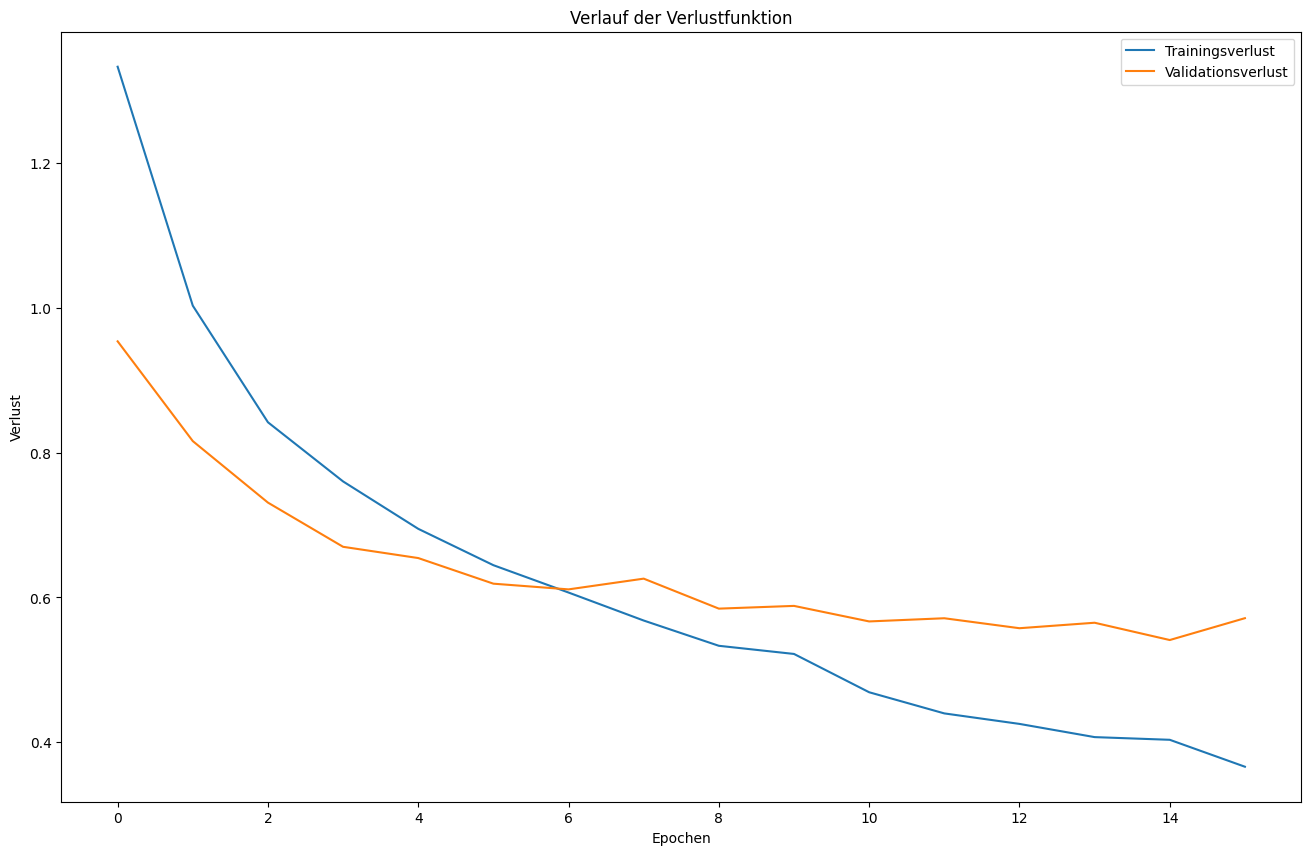

In [19]:
plt.figure(figsize=(16, 10))

plt.plot(range(epochs), history.history['loss'], label="Trainingsverlust")
plt.plot(range(epochs), history.history['val_loss'], label="Validationsverlust")

plt.xlabel("Epochen")
plt.ylabel("Verlust")
plt.legend()
plt.title("Verlauf der Verlustfunktion")

plt.show()

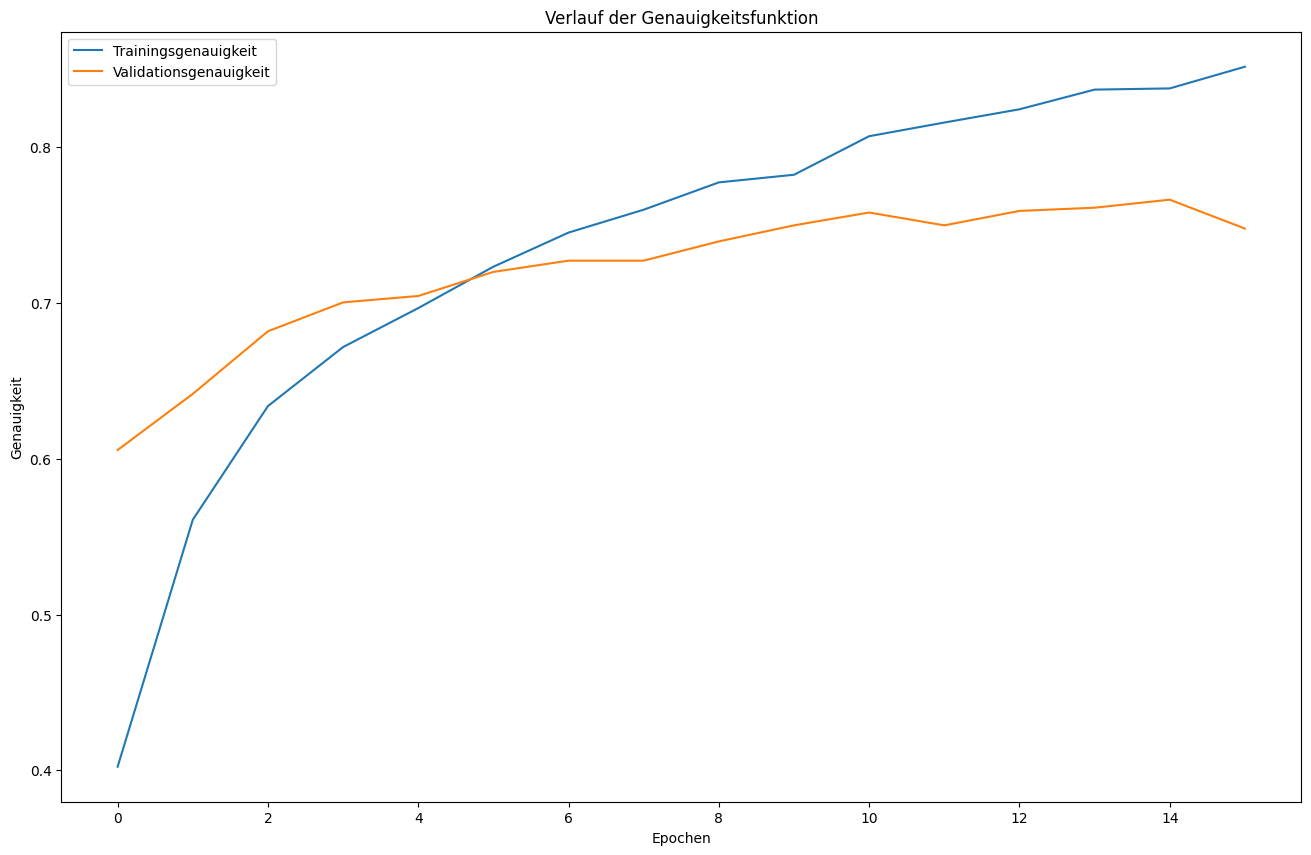

In [20]:
plt.figure(figsize=(16, 10))

plt.plot(range(epochs), history.history['accuracy'], label="Trainingsgenauigkeit")
plt.plot(range(epochs), history.history['val_accuracy'], label="Validationsgenauigkeit")

plt.xlabel("Epochen")
plt.ylabel("Genauigkeit")
plt.legend()
plt.title("Verlauf der Genauigkeitsfunktion")

plt.show()

#### ▶️ Modell auf Testdaten anwenden und evaluieren
***

In [21]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.608387291431427
Test accuracy: 0.741137683391571


In [22]:
y = model.predict(np.array(Features))[1850]
#print(X[3212])
print("Es handelt sich um Geste : " + str(np.argmax(y)))


190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Es handelt sich um Geste : 1


#### ▶️ Metriken zur Beurteilung der Modellqualität 
***

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


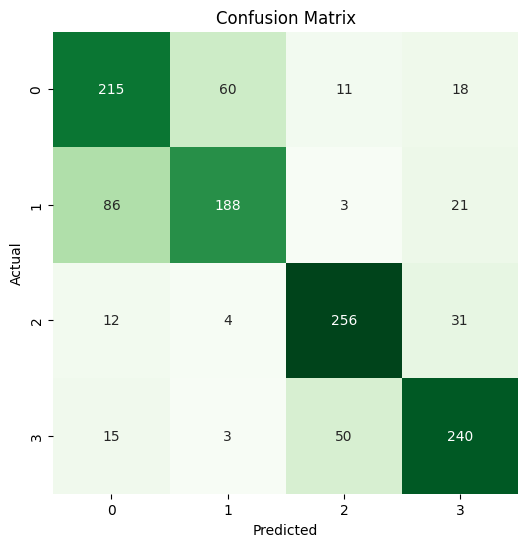

              precision    recall  f1-score   support

           0       0.66      0.71      0.68       304
           1       0.74      0.63      0.68       298
           2       0.80      0.84      0.82       303
           3       0.77      0.78      0.78       308

    accuracy                           0.74      1213
   macro avg       0.74      0.74      0.74      1213
weighted avg       0.74      0.74      0.74      1213



In [23]:
y_true = np.array(y_test)
y_pred = np.array(list(map(lambda x: np.argmax(x), model.predict(X_test))))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred))